# **Introduction to Probabilistic Thinking and Programming**

<img src="https://www.pulsecarshalton.co.uk/wp-content/uploads/2016/08/jk-placeholder-image.jpg" width="60%" />

[Add prac relevant image. Suggestions welcome!]

<a href="https://colab.research.google.com/github/deep-learning-indaba/indaba-pracs-2023/blob/main/Introduction_to_Probabilistic_Thinking_and_Programming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

© Deep Learning Indaba 2023. Apache License 2.0.

**Authors:** Elizaveta Semenova, Kira Düsterwald & James Allingham

**Reviewers:**

**Introduction:**

Thinking probabilistically and working with probability distributions can be very powerful tools for any machine learning practitioner. Unfortunately, they are tools that are often disregarded due to their *perceived* complexity. In this practical we hope to demistify these ideas by building intuition, provided practical tips, and introducing a very powerful framework for embracing the probabilistic approach – **probabilistic programming**. We'll both motivate why we need probabilistic programming and give a introduction for using it in practice.

This prac is aimed at all knowledge levels! No matter what your prior experience with probabilistic thinking and/or programming, we are sure that you will be able to take away some useful knowledge from this practical. However, this means that depending on your level, some of the content will not be aimed at you. Don't worry, this will be clearly marked at all points. We reccomend that you try and stick to our suggestions in order to get the most out of this prac in the given time, but if curiosity gets the better of you that's also great!

**Topics:**

Content: <font color='red'>`Bayesian Probability`</font>, <font color='purple'>`Probabilistic Programming`</font>

Level: <font color='blue'>`Beginner`</font>, <font color='orange'>`Intermediate`</font> & <font color='green'>`Advanced`</font>


**Aims/Learning Objectives:**

* [<font color='blue'>`Beginner`</font>] Understand what random variables and probability distributions are.
* [<font color='blue'>`Beginner`</font>] Be able to work with probability distributions using `numpyro`.
* [<font color='orange'>`Intermediate`</font>] Understand the difference between MLE, MAP, and Bayesian learning.
* [<font color='green'>`Advanced`</font>] Understanding the challenges involved in computing Bayes rule, and how probabilistic programming solved these.
* [<font color='green'>`Advanced`</font>] Be able to implement a simple probabilistic program with `numpyro`.

**Prerequisites:**

* Basic machine learning (e.g., simple supervised and unsupervised machine learning techniques).
* Basic calculus (e.g., computing an integral).
* Python programming (with `jax` and `numpy`).

**Outline:**

[Points that link to each section. Auto-generate following the instructions [here](https://stackoverflow.com/questions/67458990/how-to-automatically-generate-a-table-of-contents-in-colab-notebook).]

**Before you start:**

For this practical, you will need to use a GPU to speed up training. To do this, go to the "Runtime" menu in Colab, select "Change runtime type" and then in the popup menu, choose "GPU" in the "Hardware accelerator" box.

**Important:** you will also need to go to "Tools" > "Settings" > "Miscellaneous" > check "Crab Mode".

**Suggested experience level in this topic:**

| Level         | Experience                            |
| --- | --- |
`Beginner`      | It is my first time being introduced to this work. |
`Intermediate`  | I have done some basic courses/intros on this topic. |
`Advanced`      | I work in this area/topic daily. |

In [ ]:
# @title [TODO] **Paths to follow:** What is your level of experience in the topics presented in this notebook? (Run Cell)
experience = "advanced" #@param ["beginner", "intermediate", "advanced"]

sections_to_follow=""

if experience == "beginner":
  sections_to_follow="Introduction -> 1.1 Subsection -> 2.1 Subsection -> Conclusion -> Feedback"
elif experience == "intermediate":
  sections_to_follow="Introduction -> 1.2 Subsection -> 2.2 Subsection -> Conclusion -> Feedback"
elif experience == "advanced":
  sections_to_follow="Introduction -> 1.3 Subsection -> 2.3 Subsection -> Conclusion -> Feedback"

print(f"Based on your experience, it is advised you follow these -- {sections_to_follow} sections. Note this is just a guideline.")

Based on your experience, it is advised you follow these -- Introduction -> 1.3 Subsection -> 2.3 Subsection -> Conclusion -> Feedback sections. Note this is just a guideline.


## Installation and Imports

In [23]:
## Install and import anything required. Capture hides the output from the cell.
# @title Install and import required packages. (Run Cell)

!pip install numpyro

import jax
from jax import random
import jax.numpy as jnp
from jax import random

import numpyro.distributions as dist

from scipy.stats import gaussian_kde
import scipy.stats as stats
import math

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

In [ ]:
# @title Helper Functions. (Run Cell)

In [ ]:
# Since we are using Jax, we will need a random key:
rng = random.PRNGKey(42)

# Probability distributions and random variables – <font color='blue'>`Beginner`</font>

*Note: unless marked otherwise, all subsections in this section are <font color='blue'>`Beginner`</font> friendly.* 🙂

In order to dive into the exciting world of probabilistic thinking and programming, we first need to build some important foundations. In particular, we will need understand what a probability distribution is, some simple but fundamental rules of probability, and how to interact with probabilities in code. Along with way, we will have some opportunities to explore some practical tips and tricks that will be very useful for our exploration of probabilistic world.

Probability distributions and random variables allow us to describe and do calculations involving random events, i.e., events whose outcomes are random. An example of such a random event would be flipping a coin or rolling a die. In the first case, the possible outcomes are *heads* or *tails*.

**Group task 1:** discuss with your neighbours, what are the possible outcomes when rolling a die?


A **random variable** $X$ allows us to assign numerical values to the possible outcomes of a random event. For example in the coin flipping example we could use a binary random varible with $X = 1$ if the coin is heads and $X = 0$ for tails.

**Group task 2:** discuss with your neighbours and write down a random variable to describe the die rolling event.

A **probability distribution** $p(X = x)$ describes the probability that $X$ takes each of its possible values $x$.

In order to make things more concrete, let's explore a few common probabilty distributions.

#### Answer to group task 1

Assuming that the die has 6 sides, the outcomes are ⚀, ⚁, ⚂, ⚃, ⚄, and ⚅.

#### Answer to group task 2


Note that there are many possible answers, here is one:

$$
X = \begin{cases}
1 \text{ if } ⚀ \\
2 \text{ if } ⚁ \\
3 \text{ if } ⚂ \\
4 \text{ if } ⚃ \\
5 \text{ if } ⚄ \\
6 \text{ if } ⚅ \\
\end{cases}
$$

### The Bernoulli distribution

A Bernoulli distribution is used to describe random events with two possible outcomes e.g., when we have a random variable that takes on one of two values $x \in \{0, 1\}$:
\begin{align}
p(X = 1) &= p \\
p(X = 0) &= 1 - p
\end{align}
where $0 \le p \le 1$. Here $p$ is a parameter which controlls the probability of each outcome. For example, in the case of a *fair* coin toss, $p = 0.5$ so that both outcomes have a 50\% chance of occuring. As we will see shortly, most distributions have multiple parameters.

A probability distribution can be uniquely defined by its probability mass function (PMF), or probability desnity function (PDF) in the case of continuous distributions. For the Bernoulli distribution we write the PMF as
\begin{align}
p(X = x) = \text{Bernoulli}(X\mid p) &= \begin{cases}
p\, & \text{if } x = 1 \\
1 - p\, & \text{if } x = 0
\end{cases} \\
&= p^x(1-p)^{1-x}.
\end{align}

**Exercise:** convince yourself that the two definitions of the Bernoulli distribution shown above are equivalent.

Now let's construct a Bernoulli distribution in code, so that we can play around with it and get some intuition.

**Note:** In this practical we are going to use `numpyro` to construct our distributions. However there are several other `jax` packages that work similarly (e.g., `distrax`) as well as several options for `tensorflow` (e.g., `tensorflow_probability`) and `pytorch` (e.g., `torch.distribution`). Don't worry too much about the specifics of how `numpyro` works, e.g., the names of the distributions and their arguments, instead try to understand what the code is doing.

In [ ]:
p = jnp.array(0.5)
bernoulli = dist.Bernoulli(probs=p)

Now that we have constructed the distribution we can get a sample from it:

In [ ]:
sample = bernoulli.sample(key=rng)
print(sample)

1


And we can evaluate the probability of observing a sample.

**Note:** the distribution objects in `numpyro` (and indeed most other libraries for probability distributions) return *log*-probabilities, rather than raw probabilities. This means that we need to take the exponent if we want to know the probabilitiy.

In [ ]:
log_prob = bernoulli.log_prob(sample)
print(f"log p(X = {sample}) = {log_prob}")
print(f"p(X = {sample}) = {jnp.exp(log_prob)}")

log p(X = 1) = -0.6931471824645996
p(X = 1) = 0.5


As expected, we get a probability of 0.5.

We can also easily get multiple samples:

In [ ]:
n = 6 #@param {type:"slider", min:1, max:10, step:1}
samples = bernoulli.sample(key=rng, sample_shape=(n,))
print(samples)

[0 0 0 1 1 0]


What if we wanted to evaulate the probability of observing all of our samples?

The `bernoulli` object we created earlier treats each each sample individually, and returns the probabilities of observing each sample on its own:

In [ ]:
individual_sample_probs = jnp.exp(bernoulli.log_prob(samples))
print(individual_sample_probs)

[0.5 0.5 0.5 0.5 0.5 0.5]


But, we can use the one of the laws of probability to compute the probability of observing all of the samples together:
$$
p(X_1=x_1, X_2=x_2, \dots, X_N=x_n) = \prod_{n=1}^N p(X_n=x_n).
$$
This is called the *product rule of probability*, and it says that for *independent* random variables, the joint probability (i.e., the probability of observing them all together) is equal to the product of the individual probabilities.

Now, let's calculate the joint probability of our samples.

In [ ]:
joint_prob = jnp.prod(individual_sample_probs)
print(joint_prob)

0.015625


**Group task 3:** Discuss with your neighbour, why do you think that libraries usually return *log*-probabilities?

**Group task 4:** Play with the following slider, and make sure that you understand the role of the Bernoulli distribution's $p$ parameter.

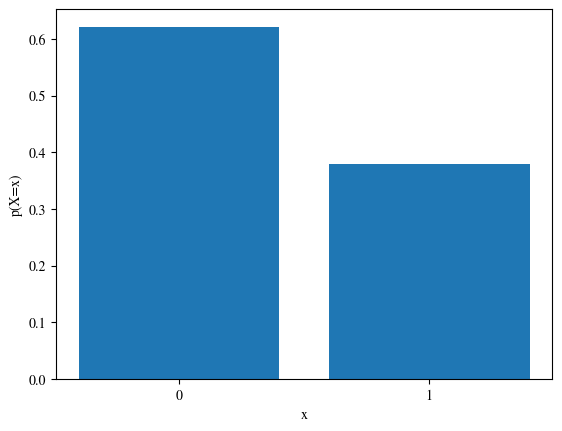

In [ ]:
#@title Bernolli distribution interactive excercise { run: "auto" }

p_ = 0.37 #@param {type:"slider", min:0, max:1, step:0.01}

n_ = 1000
bernoulli_ = dist.Bernoulli(probs=p_)
samples_ = bernoulli_.sample(key=rng, sample_shape=(n_,))

num_ones = (samples_ == 1.).sum()
num_zeros = (samples_ == 0.).sum()

fig = plt.figure(dpi=100)
ax = fig.add_subplot(1, 1, 1)
ax.bar([0, 1], [num_zeros/n_, num_ones/n_])
ax.set_xticks([0, 1])
ax.set_xlabel('x')
ax.set_ylabel('p(X=x)')
plt.show()

#### Answer to group task 3


The answer, as is often the case, is numerical stability! When working with numbers between 0 and 1 (i.e., probabilities) it is easy to run into underflow.

For example, consider computing the probability of several independent events $A$, $B$, $C$, $\ldots$:
$$
p(A, B, C, \ldots) = p(A) \times p(B) \times p(C) \times \ldots,
$$
because we are multiplying numbers that are between 0 and 1, we know that the result will be smaller for each multiplication. As we perform more and more multiplications, it becomes more likely that the computation will underflow and erroneously produce a result of 0.

We can avoid this problem by instead working with log-probabilities. Continuing the above example we get
$$
\log p(A, B, C, \ldots) = \log p(A) + \log p(B) + \log p(C) + \ldots,
$$
where by the log laws, we have replaced all of the multiplications with additions, thereby avoiding any numerical issues.

## The categorical distribution

A categorical distribution is used to model random events with multiple *discrete* outcomes, such as the die rolling event from above. By discrete, we mean that there is a countable number of outcomes. We will tackle uncountable outcomes shortly.

As with the Bernoulli distribution, we can characterise the categorical distribution with its PMF:
\begin{align}
p(X = x) = \text{categorical}(X\mid\mathbf{p}) = \prod_{k=1}^K p_k^{[x=k]},
\end{align}
where $K$ is the number of outcomes, $\textbf{p} = [p_1, p_2, \dots, p_K]$, $p_k$ is the probability of the $k$th outcome, $\sum_k p_k = 1$, and $[x = k]$ is called an Iverson bracket which evaluates to 1 if $x = k$ and 0 otherwise.

**Exercise:** convince yourself that a categorical distribution with $K = 2$ is equivalent to a Bernoulli distribution.

Now, let's start playing with this distribution in code!

In [ ]:
ps = jnp.array([0.1, 0.2, 0.3, 0.4])
categorical = dist.Categorical(probs=ps)

As before we can take some samples:

In [ ]:
samples = categorical.sample(key=rng, sample_shape=(10,))
print(samples)

[3 2 1 3 3 1 2 1 3 3]


And compute the probability for each of the random events:

In [ ]:
print(f"p(X=0) = {jnp.exp(categorical.log_prob(0)):.1f}")
print(f"p(X=1) = {jnp.exp(categorical.log_prob(1)):.1f}")
print(f"p(X=2) = {jnp.exp(categorical.log_prob(2)):.1f}")
print(f"p(X=3) = {jnp.exp(categorical.log_prob(3)):.1f}")

p(X=0) = 0.1
p(X=1) = 0.2
p(X=2) = 0.3
p(X=3) = 0.4


**Group task 5:** Play with the following sliders, which control the paramters of the categorical distribution. Note that because $\sum_k p_k = 1$, we are using an alternative way to represent the categorical distribution. Instead of specifying the probabilities $p_k$, we specifiy logits $l_k$. Each $p_k$ is then computed as
$$
p_k = \frac{\exp(l_k)}{\sum_{k'}\exp(l_k)},
$$
i.e., using the softmax function.

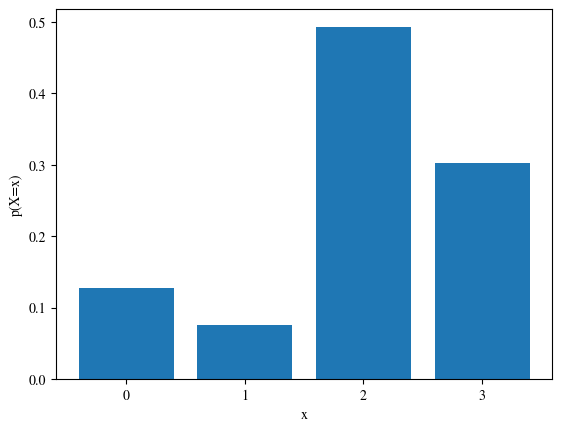

In [ ]:
#@title categorical distribution interactive excercise {run: "auto"}
l_0 = 0.7 #@param {type:"slider", max:4, step:0.1}
l_1 = 0.3 #@param {type:"slider", max:4, step:0.1}
l_2 = 2 #@param {type:"slider", max:4, step:0.1}
l_3 = 1.6 #@param {type:"slider", max:4, step:0.1}

logits_ = jnp.array([l_0, l_1, l_2, l_3], dtype=jnp.float32)
categorical_ = dist.Categorical(logits=logits_)
samples_ = categorical_.sample(key=rng, sample_shape=(1000,))

values =[0, 1, 2, 3]
hist, _ = jnp.histogram(
    samples_, bins=jnp.array(values + [4]), density=True
)

fig = plt.figure(dpi=100)
ax = fig.add_subplot(1, 1, 1)
ax.bar(values, hist)
ax.set_xticks(values)
ax.set_xlabel('x')
ax.set_ylabel('p(X=x)')
plt.show()

## The normal distribution

The normal, also known as Gaussian, distribution is one of the most common distributions for modelling *continuous* random variables, i.e., corresponding to events with an uncountable number of outcomes. It's probability density function is
$$
p(X = x) = \mathcal{N}(x\mid \mu, \sigma) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(-\frac{(\mu - x)^2}{2\sigma^2}\right),
$$
where $\mu$ and $\sigma$ are the *mean* and *standard deviation* (also called the location, and scale or square-root of the *variance* $\sigma^2$, respectively).

Once again, the best way to get a sense for this distribution is to play with some code!

**Group task 6:** play with the following sliders, and discuss with your neighbours – how do the mean and standard deviation affect the samples?

In [ ]:
normal = dist.Normal(loc=0., scale=1.)
sample = normal.sample(key=rng)
print(f"p(X = {sample}) = {jnp.exp(normal.log_prob(sample)):.5f}")

p(X = -0.1847117692232132) = 0.39219


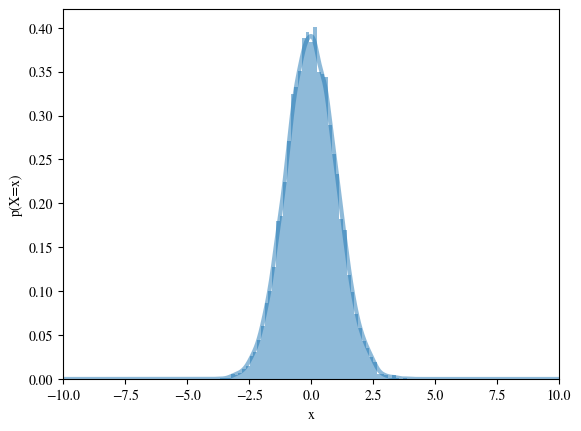

In [ ]:
#@title normal distribution interactive excercise {run: "auto"}
μ_ = 0 #@param {type:"slider", min:-5, max:5, step:0.1}
σ_ = 1 #@param {type:"slider", max:4, step:0.1}

normal = dist.Normal(loc=μ_, scale=σ_)
samples_ = normal.sample(key=rng, sample_shape=(10000,))

fig = plt.figure(dpi=100)
ax = fig.add_subplot(1, 1, 1)
ax.hist(samples_, bins=50, density=True, alpha=0.5)
x = jnp.linspace(-10, 10, 3000)
kde = gaussian_kde(samples_)
ax.plot(x, kde(x), color='C0', lw=3, alpha=0.5)
ax.set_xlabel('x')
ax.set_ylabel('p(X=x)')
ax.set_xlim(-10, 10)
plt.show()

In [ ]:
#@title Implementing the normal PDF from scratch!
#@markdown **code task 1:** Let's implement the PDF for the normal distribution from scratch, just using functions from `jax`.
#@markdown *Hint:* You may want to use `jnp.pi`, `jnp.sqrt`, and `jnp.exp`.

def normal_pdf(loc, scale, x):
    p_x =  # TODO: your code goes here!

    return p_x

In [ ]:
# @title Run me to test your code

def test_normal_pdf(pdf_fn):
  assert pdf_fn(0, 1, 0) == jnp.exp(dist.Normal(loc=0, scale=1).log_prob(0)), "Normal(X=0|0, 1) is incorrect."
  assert pdf_fn(0, 2, 0) == jnp.exp(dist.Normal(loc=0, scale=2).log_prob(0)), "Normal(X=0|0, 2) is incorrect."
  assert pdf_fn(0, 1, 1) == jnp.exp(dist.Normal(loc=0, scale=1).log_prob(1)), "Normal(X=0|1, 1) is incorrect."
  assert pdf_fn(2, 3, 1) == jnp.exp(dist.Normal(loc=2, scale=3).log_prob(1)), "Normal(X=1|2, 3) is incorrect."
  print("Nice! Your answer looks correct.")

test_normal_pdf(normal_pdf)

In [ ]:
# @title Answer to code task 1 (Try not to peek until you've given it a good try!')

def normal_pdf(loc, scale, x):
    p_x = 1 / jnp.sqrt(2 * jnp.pi * scale**2)
    p_x *= jnp.exp(-((loc - x)**2) / (2 * scale**2))

    return p_x

test_normal_pdf(normal_pdf)

#### Answer to group task 6



The mean controls where the center of the distribution is located. In other words, it controls where the most likely *location* to sample a values is.

The standard deviation controls how wide the distribution is. In other words, it controls how likely we are to draw samples farther away from the mean.

### Expected Values

The expected value of a random variable is the value that we expect to get on average when we sample a large number of different outcomes from the random event.

For example, if we consider our example of flipping a coin from above, where $X = 1$ if the coin lands on heads and $X = 0$ if the coint lands on tails, then intuitively the expected value is $0.5$.

More precisely, we can write the expected value as
$$
\mathbb{E}[X] = \sum_x x \cdot p(X=x),
$$
for a discrete random variable $X$. For a continuous random varaible, the sum would be replaced with an integral. From this definition, we can think of the expected value as a weighted average of all of the values of $X$, where the weighting for each value is the probability of observing it.

**Group task 7:** Working with your neighbour, compute the expected value for the standard six-sided die rolling event from above.

#### Answer to group task 7

Assuming that we use the following random variable to represent our die throw
$$
X = \begin{cases}
1 \text{ if } ⚀ \\
2 \text{ if } ⚁ \\
3 \text{ if } ⚂ \\
4 \text{ if } ⚃ \\
5 \text{ if } ⚄ \\
6 \text{ if } ⚅ \\
\end{cases}
$$
the expected value is
$$
\mathbb{E}[X] = \frac{1}{6} \cdot 1 + \frac{1}{6} \cdot 2 + \frac{1}{6} \cdot 3 + \frac{1}{6} \cdot 4 + \frac{1}{6} \cdot 5 + \frac{1}{6} \cdot 6 = 3.5.
$$

#### Monte-Carlo estimation

Instead of computing an expected value exactly, we can estimate it using a *Monte-Carlo* approximation.  We can describe this procedure using the following mathematical notation:
$$
\mathbb{E}[X] \approx \frac{1}{N} \sum_{n=1}^{N} x_n\,, \quad x_n \sim p(X).
$$
That is, we sample $N$ values $x_n$ from $p(X)$ and then take the average. Because the values appear proportionally to their probabilities, for large values of $N$, this approximation will become accurate.

We can also implement this in code! Let's calculate the expected value of the normal distribution $\mathcal{N}(x \mid \mu, \sigma)$.

**Group task 8:** Working with your neighbours, play with the following sliders, and try to answer these questions:
1. Start with a large value for $N$ and a small value for $\sigma$, what number does the expected value approximate? *Hint:* change the value of $\mu$ and see what happens to the expected value.
2. Now, start decreasing $N$ and/or increasing $\sigma$. What happens to the expected value?
3. What notation in the equation above do lines 7 and 9 in the code bellow correspond to?

In [ ]:
#@title Expected value interactive excercise {run: "auto"}
N = 100 #@param {type:"slider", min:1, max:400, step:1}
μ = 0 #@param {type:"slider", min:-5, max:5, step:0.1}
σ = 1 #@param {type:"slider", min: 0.1, max:4, step:0.1}

normal = dist.Normal(loc=μ, scale=σ)
samples = normal.sample(key=rng, sample_shape=(N,))

expected_value = jnp.sum(samples) / N

print(f'E[X] = {expected_value:.5f}')

E[X] = 0.00990


##### Answer to group task 8


1. The expected value for a random variable with a normal distribution is the mean parameter $\mu$. For this reason the term *mean* is often used synonimously with *expected value*.
2. As we decrease $N$ and/or increase $\sigma$, the Monte Carlo approximation becomes less accurate. **Fun fact**, for a standard Monte Carlo approximator such as this, the approximation error decreases at a rate of $\sqrt{N}$. In other words, if we multiply $N$ by 4, the error in the approximation should be divided by 2.

#### Functions of random variables

We can also calculate expected values of functions of random variables. For example, the variance of a random variable can be caculated using the following expected value
$$
\mathbb{V}[X] = \mathbb{E}[(X - \mu)^2],
$$
where $\mu = \mathbb{E}[X]$ is the mean, as described above.

In [ ]:
#@title Estimating the variance - <font color='orange'>`Intermediate`</font>
#@markdown **[Optional] code task 2:** Let's implement a Monte Carlo estimator for the variance.
#@markdown You can tell if your answer is correct if the estimated variance is close to $\sigma^2$ for large $N$.

N = 100 #@param {type:"slider", min:1, max:400, step:1}
μ = 0 #@param {type:"slider", min:-5, max:5, step:0.1}
σ = 1 #@param {type:"slider", min: 0.1, max:4, step:0.1}

normal = dist.Normal(loc=μ, scale=σ)
samples = normal.sample(
    key=rng, sample_shape=(N,)
)

# TODO: your code goes here!

print(f'V[X] = {var:.5f}')


V[X] = 1.03964


In [ ]:
# @title Answer to code task 2 (Try not to peek until you've given it a good try!')

normal = dist.Normal(loc=μ, scale=σ)
samples = normal.sample(
    key=rng, sample_shape=(N,)
)

mean = jnp.mean(samples)
var = jnp.mean((samples - mean)**2)

print(f'V[X] = {var:.5f}')

### [Optional] Reparameterisation - <font color='orange'>`Intermediate`</font>

Just for fun, let's explore an interesting (and useful!) property of the normal distribution.

Let's say we have samples $x_n$ from a $\mathcal{N}(x|0, 1)$ distribution, but what we really want is samples $y_n$ from $\mathcal{N}(y|\mu, \sigma)$. It turns out, that we can easily convert from $x_n$ to $y_n$, or vice-versa. To be specific, we can convert between the random variable $X$ to the random variable $Y$, as follows
$$
Y = \sigma X + \mu
$$
or
$$
X = Y/\sigma - \mu/\sigma.
$$

In fact, this property is several other probability distributions called the location-scale family. All of these distribuions have the similarity that they are parameterised by a location parameter $\mu$ and a scale paramter $\sigma$! Converting from one distribution to another like this is called *reparameterisation*.

As usual, let's convince ourselves that this is true with some code 😎

In [ ]:
normal_x = dist.Normal(loc=0, scale=1)
samples_x = normal_x.sample(key=rng, sample_shape=(5,))

μ = 1
σ = 2
normal_y = dist.Normal(loc=μ, scale=σ)
samples_y = normal_y.sample(key=rng, sample_shape=(5,))
# Note that we are using the same random key as above.

print(f"xs =\t\t{samples_x}")
print(f"ys =\t\t{samples_y}")
print(f"xs*σ + μ =\t{samples_x * σ + μ}")

xs =		[ 0.6122652  1.1225883 -0.8544134 -0.8127325 -0.890405 ]
ys =		[ 2.2245305   3.2451766  -0.7088268  -0.62546504 -0.78081   ]
xs*σ + μ =	[ 2.2245305   3.2451766  -0.7088268  -0.62546504 -0.78081   ]


#### [Optional] Extra reading – the reparameterisation trick - <font color='green'>`Advanced`</font>

When using gradient descent to learn the parameters of the distribution probability distribution given samples from that distribution, we run into a problem. It is not possible to back-propagate through a random operation like sampling. However, if we distribution we are trying to learn is reparameterisable (e.g., it is a from the location-scale family), then we can get around this issue. As an example, instead of doing
$$
z_i \sim \mathcal{N}(z\mid \mu, \sigma),
$$
we do
\begin{align}
x_i &\sim \mathcal{N}(x\mid 0, 1), \\
z_i &= x_i * \sigma + \mu.
\end{align}
As illustrated in the diagram below, this allows us to do back-propagation as required.

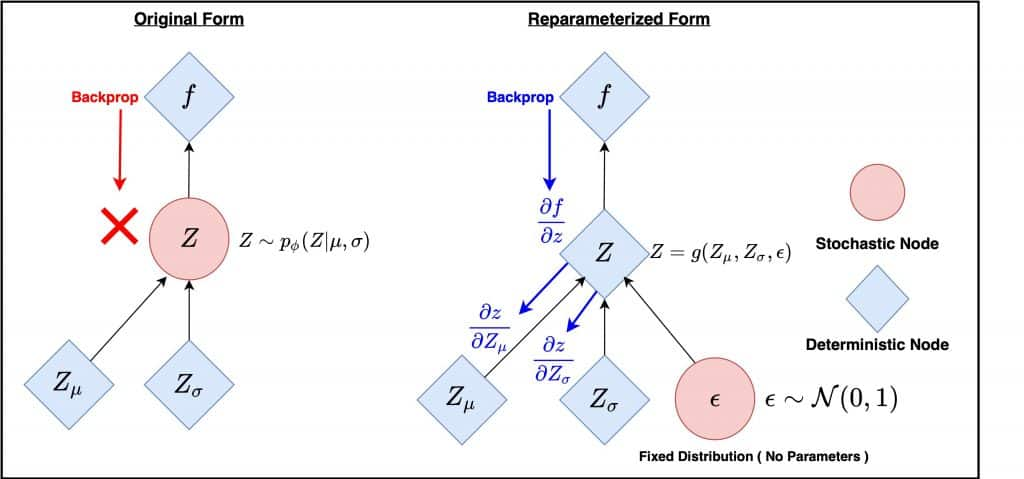

## The *multivariate* normal distribution

*Note: some of the mathematics (involving matrix algebra) in this section is slightly more complicated and may be closer to an <font color='orange'>`Intermediate`</font> level. If you are struggling with the matrices don't worry! We also present the special two-dimmensional case, which doesn't involve any matrices. The important take-aways here are not the mathematics, but rather the concepts and intuitions which are still 100% certified <font color='blue'>`Beginner`</font> friendly.* 🙌

TODO: introduce the idea of multivariate distribution and covariance via the multivariate normal.



### The sum rule and the product rule revisited!

TODO: now that we have a multivariate distribution we can properly introduce the sum and product rules.

### Batch and event shapes

In [ ]:
values = jnp.array([1., 2.])
normal = dist.Normal(0., 1.)
print(normal.event_shape)
print(normal.batch_shape)
print(f"p(X = {values}) = {jnp.exp(normal.log_prob(values))}")

In [ ]:
batch_normal = dist.Normal(jnp.array([0., 1.]), jnp.array([1., 2.]))
print(batch_normal.event_shape)
print(batch_normal.batch_shape)
print(f"p(X = {values}) = {jnp.exp(batch_normal.log_prob(values))}")
print(jnp.prod(jnp.exp(batch_normal.log_prob(values))))

In [ ]:
multivariate_diagonal_normal = dist.MultivariateNormal(jnp.array([0., 1.]), jnp.array([[1., 0.], [0., 2.**2]]))
print(multivariate_diagonal_normal.event_shape)
print(multivariate_diagonal_normal.batch_shape)
print(f"p(X = {values}) = {jnp.exp(multivariate_diagonal_normal.log_prob(values))}")

In [ ]:
multivariate_full_normal = dist.MultivariateNormal(jnp.array([0., 1.]), jnp.array([[1., 1.], [1., 2.**2]]))
print(multivariate_full_normal.event_shape)
print(multivariate_full_normal.batch_shape)
print(f"p(X = {values}) = {jnp.exp(multivariate_full_normal.log_prob(values))}")

## An important note on notation

In the text above we introduced a lot of new notation, so let's spend a little more time to make sure that everything is clear before moving on.

**$X$ vs $x$**

**$p(X = x)$ vs $p(X)$ vs $p_X(x)$ vs $p(x)$**

**What is the '$\mid$' in $p(X\mid a, b, c)$?**

## Task – comparing the normal distribution and another continuous distribution

Beta

### [Optional] comparing distributions with the KL-divergence – <font color='orange'>`Intermediate`</font>

# Bayesian inference: What, Why, How.

*What you will learn:*

- What is Bayesian inference?
- Why do we care?
- How to perform Bayesian inference: a painful way and a modern way.

## *What* is Bayesian inference?


In short, Bayesian inference is the process of deducing properties of a probability distribution from data using Bayes’ theorem.


Bayesian inference is a method of statistical inference in which probability is used to **update beliefs** about model's parameters based on available **evidence or data**.

## Thomas Bayes and Simon Pierre Laplace
It is named after the 18th-century mathematician and philosopher Thomas Bayes.
[insert image]

- Started with these two.
- Bayes is why it's called <span style="color:red;">Bayes</span>ian.
- Sorry Laplace!

## Subjective probability

- What about the probability that it will rain tomorrow?
- What is the probability that the next president will be a woman?
- What is the probability that aliens built the pyramids?
- Such questions cannot be answered by long-run probability.
- Degree of belief involved.
- However, long-run reasoning can inform these estimations.
- Foundation of Bayesian thinking.

## Conditional probability

Conditional probability of A given B:

$$P(A \vert B)=\frac{P(A \cap B)}{P(B)}.$$


[insert image conditional_b.png]


$$P(A \vert B)$$ - probability of event A given B has occured<br>
$$P(A \cap B)$$ - probability of event A occured and B occured

## Conditional probability - example

In a group of 100 DLI attendees, 40 chose to attend the Bayesian Inference practical, 30 chose to attend two practicals on this day, and 20 chose attend BI among those two....

$$
P(A|B) = \frac{P(A \cap B)}{P(B)} = 20 / 40 = 0.5
$$

## Bayes theorem

Conditional probability is the axis on which Bayesian statistics turns.

Same equation...

...but different interpretation.

 $$
  P(B|A) = \frac{P(A|B) P(B)}{P(A)}
  $$

## Prior, likelihood and posterior

 $$
  P(\theta|y) \propto P(y|\theta) P(\theta)
  $$
 $P(\theta)$ is the prior
 $P(y|\theta)$ is the likelihood
 $P(\theta|y)$ is the posterior

- Prior is what is known or estimated a priori
- Likelihood is probability of data given parameters of interest
- Posterior is probability of parameters of interest given data

## Choosing the prior distribution (conjugate or not)

- Prior choice is vital.
- Type of distribution (we will see in a second).
- Hyperparameters/hyperpriors.
- Often a 'natural' candidate for prior choice.
- Mathematically solvable or not.
- Some are (conjugate)
- Most are not (non-conjugate)...

## Binomial-Beta

Binomial distribution is when there is success (1) or failure (0) with the proportion of success ($\pi$) in $n$ trials:

 $$y|\pi \sim Binomial(\pi,n)$$

Beta distribution is  the conjugate of binomial defined by two parameters $a$ and $b$.

Beta distributuon is 'natural' fit becasue it ranges from 0 to 1.

 $$\pi \sim Beta(a,b)$$

Because of conjugacy, posterior can be found analytically:

$$p(\pi|y) \sim Beta(y+a,n-y+b)$$

## Informative or non-informative priors

- Main source of criticism from non-Bayesians is how priors are chosen.
- Priors should be informed by existing knowledge.
- But what if we don't know anything really prior to inference?
- Non-informative/informative priors outside scope of this but something to pay attention to.

## Why sample?

- Because most are non-conjugate.
- Need non-analytical solution to infer distributions.

## Why use Bayesian inference?
<br>

- Prior knowledge

- Flexible in uncertainty modeling, particularly under small amount of available data

- Very flexible model formulation accounting for the mechanistic knowledge about a system

Note:
- Results are essentially equal with enough data, i.e. the posterior approximates the MLE

# Bayesian inference: examples and intuition.


### Example: diagnosing the cause of headache

<div align="center">

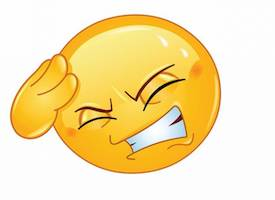
</div>

Imagine a situation where you need make a decision concerning your health. You have a headache, and anc chose between two doctors:

**Doctor 1:**
- Has a mental model for the cause of pain,
- Perform tests.

**Doctor 2:**
- Has a mental model for the cause of pain,
- Hass access to patient's history,
- Perform tests.

Which doctor do you choose?

Inference without priors is like a doctor who never reads patient's history even for patients with chronic conditions.

## Example: diagnosing flu.

For two simple events, Bayes' theorem can be written as

$$ p(A|B) = \frac{p(B|A) p(A)}{p(B)}.$$


**Group task:** We know that the probability of having fever this time of the year is 10%, probability of having a flu this time of the year is 7%, and among all people having a flu, 70% of them have fever.
Find probability of a patient having a flu given they have high temperature.



**Group task NN:** discuss with your neighbours, what are the possible outcomes when rolling a die?

## How can we perform Bayesian inference?

### What does it take?
- Data,
- A generative model,
- Our beliefs before seeing the data.

### What does it make?
- The values of parameters that could give rise to the observed data **in the form of a distribution**.

### How can we perform Bayesian inference?

- **Analytically**
        
     This is an elegant approach. However, it is rarely available in real life.

- **Numerically**

    - Rather than deriving a posterior distribution in the closed form, we can use computational tools to **sample** from the posterior. The obtained samples describe the distributions of parameters.
    
    - We achieve this by exploring the space of parameters to find the most probable combinations of parameters.
    
    - Further we treat the obtained sampled as new data, to extract information about parameters, such as mean, credible interval or other statistics.

## Example of analytical derivation of posterior

Normal-Normal

## Numerically

- Markov Chain Monte Carlo (MCMC) family of algorithm, e.g.
  * Metropolis-Hastings
  * Gibbs
  * Hamiltonian Monte Carlo (HMC)
  * No-U-Turn sampler (NUTS)
  * further variants such as SGHMC, LDHMC, etc
- Variational Bayes
- Approximate Bayesian Computation (ABC)
- Particle filters
- Laplace approximation

## Priors

<br>

- informative / non-informative

- **conjugate priors** guarantee that the posterior has an easily calculable form


    
<div align="center">
<img src="https://github.com/elizavetasemenova/indaba-pracs-2023/blob/intro-to-probability/conjugate_families.png?raw=1" width="350">
    
        Some conjugate families of distributions
    (Robert, Casella, "Monate Carlo Statistical Methods")
</div>

# Probabilistic programming.


[Probabilistic programming](https://en.wikipedia.org/wiki/Probabilistic_programming) is a paradigm in computer programming that enables the creation of models and algorithms capable of handling uncertainty and randomness. It combines principles from probability theory and programming to build systems that can reason about uncertain data and make informed decisions. This approach allows developers to express complex models in a natural and intuitive way, enabling tasks such as Bayesian inference, machine learning, and statistical analysis to be performed more effectively.

In this section we will give an overview of the modern landscape of probabilistic programming languages (PPLs), and demonstrate abilities of one of them.

Familiarity with a PPL will equip participants with a tool allowing them to focus on the scientific problem of interest, while inference is being taken care of by the inference engine. We will show how to use the [NumPyro](https://num.pyro.ai/en/latest/index.html#) library to perform exact Bayesian inference (using Markov Chain Monte Carlo).

### Influence of priors

Let us explore how much priors can actually influence posterior. Since tha marginal distribution $p(y)$ does not depend on the parameters, we will only explore the posterior up the to proportionality term

$$p(\theta |y ) ∝ p(y| \theta) p(\theta).$$

If we have access to point-wise evaluations of the likelihood $p(y | \theta)$ and prior $p(\theta)$, we can compute their product to obtain posterior.

Consider the coin tossing problem, which we describe using the Binomial distribution. Out of
$$n=10$$
tosses we obtained
$$h=6$$
successes. What is the probability of 'success' for this coin?

In [25]:
##############################################
# prioir x likelihood = posterior
##############################################

h=6

n=9

# define grid
grid_points=100

# define regular grid in the (0,1) interval
p_grid = jnp.linspace(0, 1, grid_points)

# compute likelihood at each point in the grid
likelihood = stats.binom.pmf(h, n, p_grid)

In [26]:
def computePosterior(likelihood, prior):
    # this functionm computes posterior
    # and plots the result

    # compute product of likelihood and prior
    unstd_posterior = likelihood * prior

    # standardize posterior
    posterior = unstd_posterior / unstd_posterior.sum()

    plt.figure(figsize=(17, 3))
    ax1 = plt.subplot(131)
    ax1.set_title("Prior")
    plt.plot(p_grid, prior)

    ax2 = plt.subplot(132)
    ax2.set_title("Likelihood")
    plt.plot(p_grid, likelihood)

    ax3 = plt.subplot(133)
    ax3.set_title("Posterior")
    plt.plot(p_grid, posterior)
    plt.show()

    return

**Prior1 - Uniform.**

Our first prior will be a Uniform distribution:

$$p(\theta) = 1.$$

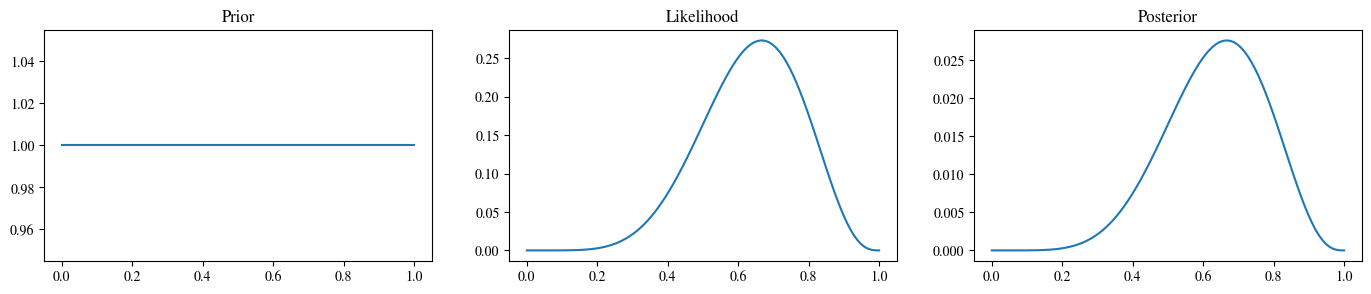

In [28]:
# Unifrom prior
prior1 = jnp.repeat(1, grid_points)

# visulaise prior, likelihood, posteroir
posterior1 = computePosterior(likelihood, prior1)

**Prior2 - step-function.**

**Group task NN**

Implement the step-function prior:

$$p(\theta) = 1.$$

$$
p(\theta) = \begin{cases}
0 \text{ if } \theta <= 0.5 \\
1 \text{ otherwise. }
\end{cases}
$$

How do you think will the posterior change?


#### Answer to group task NN

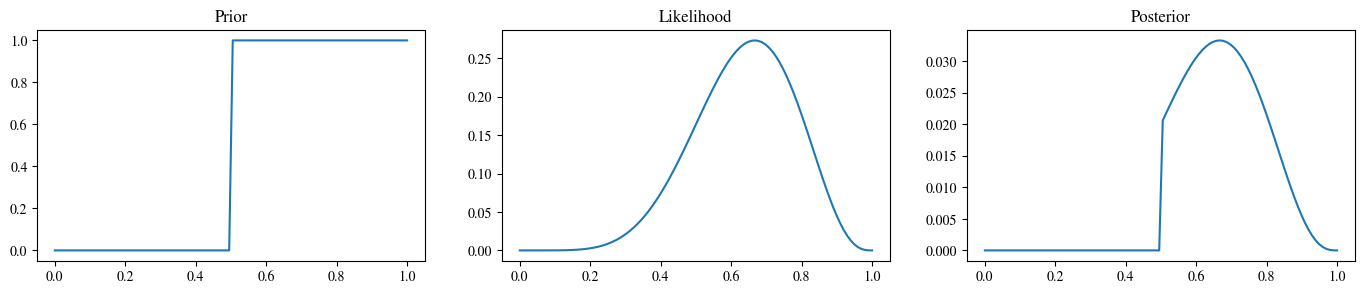

In [30]:
prior2 = (p_grid >= 0.5).astype(int)
posterior2 = computePosterior(likelihood, prior2)

And the third prior:

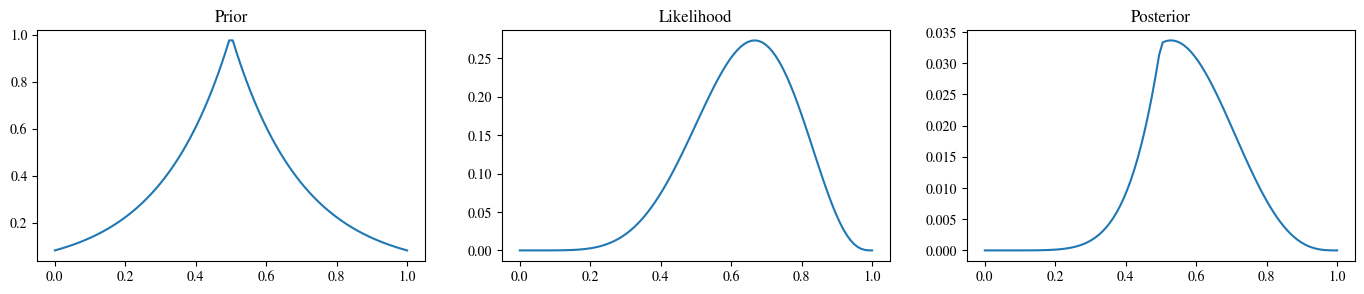

In [31]:
prior3 = jnp.exp(- 5 * abs(p_grid - 0.5))
posterior3 = computePosterior(likelihood, prior3)

## The Monte Carlo method

is a group of algorithms which use random sampling repeatedly to make numerical estimations of unknown qunatities/parameters (originated within the Manhattan Project thanks to Stanislaw Ulam).

Let us tacke the following problem:

Find approximate value of $\pi.$

Note: we are solving a **deterministic** problem using **probabilistic methods**, i.e. random number generation.

In [34]:
##############################################
# the Monte Carlo method - compute pi
##############################################

def in_circle(x, y, r):
    # is point (x,y) within circle of radius r?

    return jnp.sqrt(x **2 + y**2) <= r**2

In [35]:
def approx_pi(r, n):

    xs, ys, cols = [], [], []

    count = 0

    for i in range(n):
        x = np.random.uniform(0,r,1)
        y = np.random.uniform(0,r,1)
        xs.append(x)
        ys.append(y)

        if in_circle(x, y, r):
            count += 1
            cols.append("red")
        else:
            cols.append("steelblue")

    pi_appr = round(4 * count/n, 3)

    plt.figure(figsize=(3, 3))
    plt.scatter(xs, ys, c = cols, s=2)
    plt.title("pi (approximately) = " + str(pi_appr))
    plt.xticks([])
    plt.yticks([])
    plt.show()

    return pi_appr

**Group task NN.**

Using the functions above, iterate $n$ through vaules $5*10^1, 5*10^2, 5*10^3$ and run the function approximating $\pi$. How does the result change?

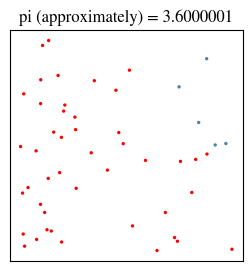

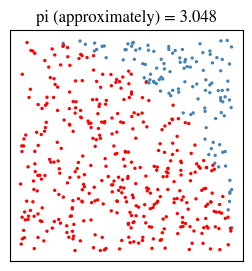

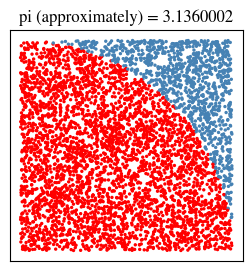

In [37]:
r = 1

for n in 5*10**jnp.array([1,2,3]):
    approx_pi(r, n)

## Monte Carlo integration

The same principle - of using random sampling to solve deterministic problems - can be applied to computing integral of a function.

Problem to solve: find value of the integral

$$\int_a^b f(x)dx. $$

Monte Carlo integration estimates this integral by estimaing the fraction of random points that fall below $f(x)$.

In our context, we are interested in estimating expectations

$$ E[h(x)] = \int h(x)f(x)dx,$$

which can be done with

$$ \bar{h}_n = \frac{1}{n} \sum_i^n h(x_i),$$
where $x_i ∼ f$ is a draw from the density $f$.

The convergence of Monte Carlo integration is $0(n^{1/2})$ and independent of the dimensionality. Hence Monte Carlo integration **generally** beats numerical intergration for moderate- and high-dimensional integration since numerical integration (quadrature) converges as $0(n^d)$.

### Monte Carlo integration - Example

Estiamte the integral $\int_0^1 e^x dx$.

In [38]:
##############################################
# the Monte Carlo method - integration
##############################################

In [39]:
jnp.exp(1) - jnp.exp(0)

Array(1.7182817, dtype=float32, weak_type=True)

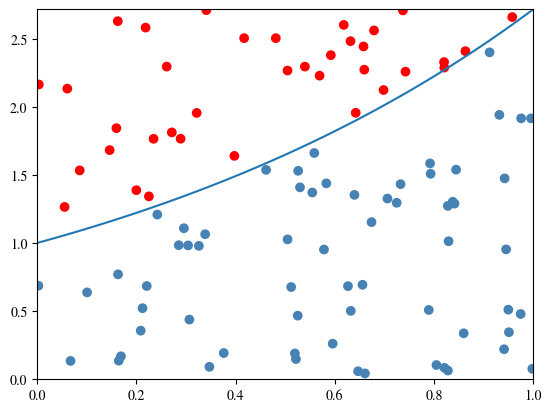

In [40]:
x = jnp.linspace(0, 1, 100)
plt.plot(x, jnp.exp(x));
pts = np.random.uniform(0,1,(100, 2))
pts[:, 1] *= jnp.e

cols = ['steelblue'] * 100
for i in range(100):
    if pts[i,1] > jnp.exp(pts[i,0]):     # acceptance / rejection step
        cols[i] = 'red'

plt.scatter(pts[:, 0], pts[:, 1], c = cols)
plt.xlim([0,1])
plt.ylim([0, jnp.e]);

In [41]:
# Monte Carlo approximation

for n in 10**np.array([1,2,3,4,5,6,7,8]):
    pts = np.random.uniform(0, 1, (n, 2))
    pts[:, 1] *= jnp.e
    count = jnp.sum(pts[:, 1] < jnp.exp(pts[:, 0]))
    volume = jnp.e * 1 # volume of region
    sol = (volume * count)/n
    print('%10d %.6f' % (n, sol))

        10 1.902797
       100 1.739700
      1000 1.799503
     10000 1.708440
    100000 1.722983
   1000000 1.718329
  10000000 1.718885
 100000000 1.718160


## Coin tossing

How to derive the MLE estimate?

$$L (\theta) = \theta^\text{heads} (1-\theta)^\text{tails}  $$


$$\log L (\theta) = \text{heads} * \log \theta +  \text{tails} * \log (1-\theta)  $$

$$ \frac{d \log L}{ \ d \theta} = \frac{\text{heads}}{\theta} + \frac{\text{tails}}{1-\theta} = 0 $$

and so

$$ \hat{\theta} = \frac{\text{heads}}{\text{heads + tails}} $$

### Approach without priors

In [42]:
##############################################
# coin tossing
##############################################

n = 10
h = 6
p = h/n
print(p)

0.6


### The Bayesian way

Beta distribution:

$$ \text{Beta}_\theta(a,b)  = C * \theta^{(a-1)} (1 - \theta)^{(b-1)} $$

If we compute the posterior distribution analytically, we will obtain a Beta distribution with new parameters.

In [43]:
a, b = 10, 10                   # hyperparameters
prior = stats.beta(a, b)        # prior
post = stats.beta(h+a, n-h+b)   # posterior

In [44]:
def beta_binomial(n, h, a, b):
    # frequentist
    p = h/n
    rv = stats.binom(n, p)
    mu = rv.mean()

    # Bayesian
    prior = stats.beta(a, b)
    post = stats.beta(h+a, n-h+b)

    thetas = np.linspace(0, 1, 200)
    plt.figure(figsize=(8, 6))
    plt.plot(thetas, prior.pdf(thetas), label='Prior', c='blue')
    plt.plot(thetas, post.pdf(thetas), label='Posterior', c='red')
    plt.plot(thetas, n*stats.binom(n, thetas).pmf(h), label='Likelihood', c='green')
    plt.axvline((h+a-1)/(n+a+b-2), c='red', linestyle='dashed', alpha=0.4, label='MAP')
    plt.axvline(mu/n, c='green', linestyle='dashed', alpha=0.4, label='MLE')
    plt.xlim([0, 1])
    plt.xlabel(r'$\theta$', fontsize=14)
    plt.ylabel('Density', fontsize=16)
    plt.legend();

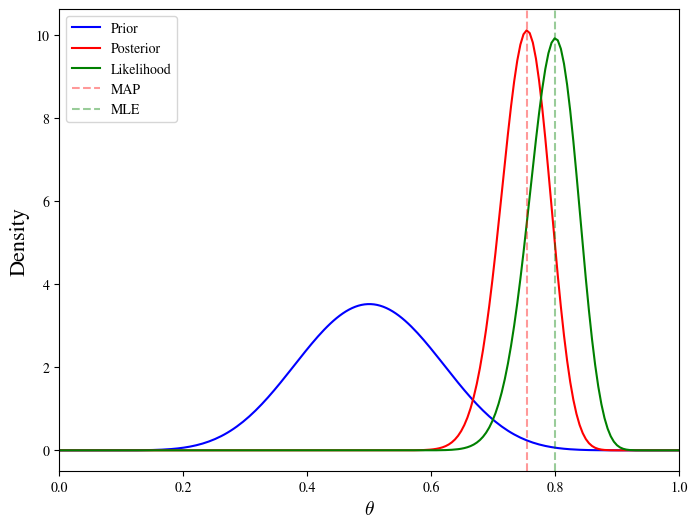

In [45]:
beta_binomial(100, 80, 10, 10)

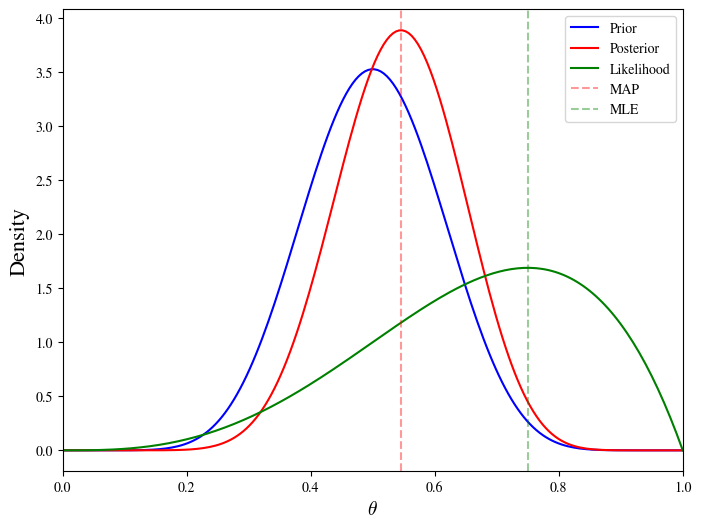

In [46]:
beta_binomial(4, 3, 10, 10)

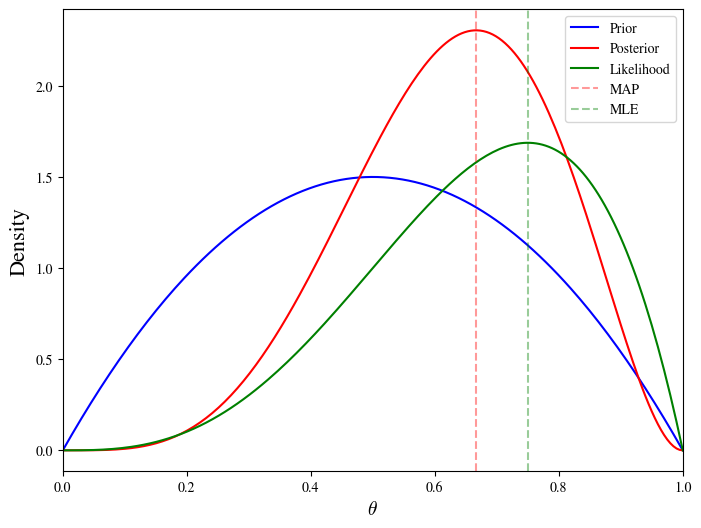

In [47]:
beta_binomial(4, 3, 2, 2)

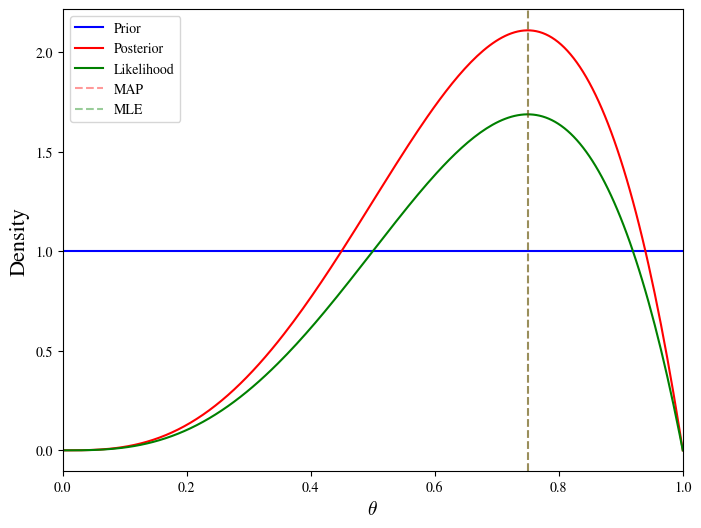

In [48]:
beta_binomial(4, 3, 1, 1)

## Markov Chain Monte Carlo

 - We want to estiamte the posterior distribution, but this is often intractable


#### Markov Chain Monte Carlo idea:

- draw samples from a (simple) proposal distribution so that each draw depends only on the state of the previous draw (i.e. the samples form a Markov chain)
- under certain conditions, the Markov chain will have a unique stationary distribution

- we set up an acceptance criteria for each draw based on comparing successive states with respect to a target distribution that enusre that the stationary distribution is the posterior distribution we are searching for

- there is no need to evaluate the potentially intractable marginal likelihood

- after sufficient number of iterations, the Markov chain of accepted draws will converge to the staionary distribution, and we can use those samples as (correlated) draws from the posterior distribution, and find functions of the posterior distribution

## Metropolis-Hastings random walk algorithm

- Start with an initial guess for $\theta$

- Chose a new proposed value as $\theta_p = \theta + \delta_\theta, \delta_\theta \sim N(0, \sigma).$
   
  Here we have chosen the proposal distribution to be $N(0, \sigma).$
  
- If $g$ is the posterior probability, calculate the ratio $\rho = \frac{g(\theta_p \mid X)}{g(\theta \mid X)}$

- (adjust for symmetry of the proposal distribution)


- If $\rho \ge 1,$ accept $\theta = \theta_p;$ if $\rho < 1,$ accept  $\theta = \theta_p$ with probability $p,$ otherwise keep $\theta = \theta.$ (This step is done with the help of the standard Uniform distribution)

In [49]:
##############################################
# Metropolis-Hastings
##############################################

Portion of accepted steps = 0.1836


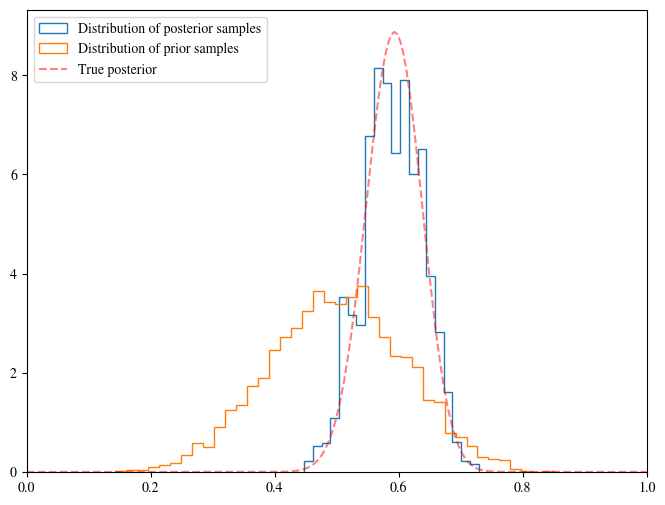

In [55]:
def target(likelihood, prior, n, h, theta):
    if theta < 0 or theta > 1:
        return 0
    else:
        return likelihood(n, theta).pmf(h)*prior.pdf(theta)

n = 100
h = 61
a = 10
b = 10
likelihood = stats.binom
prior = stats.beta(a, b)
sigma = 0.3

naccept = 0
theta = 0.1
niters = 10000

samples = np.zeros(niters+1)
samples[0] = theta

for i in range(niters):
    theta_p = theta + stats.norm(0, sigma).rvs()
    rho = min(1, target(likelihood, prior, n, h, theta_p)/target(likelihood, prior, n, h, theta ))
    u = np.random.uniform()
    if u < rho:
        naccept += 1
        theta = theta_p
    samples[i+1] = theta

nmcmc = len(samples)//2
print("Portion of accepted steps = " + str(naccept/niters))

post = stats.beta(h+a, n-h+b)
thetas = np.linspace(0, 1, 200)

plt.figure(figsize=(8, 6))
plt.hist(samples[nmcmc:], 20, histtype='step', linewidth=1, label='Distribution of posterior samples', density =True);
plt.hist(prior.rvs(nmcmc), 40, histtype='step',  linewidth=1, label='Distribution of prior samples', density=True);
plt.plot(thetas, post.pdf(thetas), c='red', linestyle='--', alpha=0.5, label='True posterior')
plt.xlim([0,1]);
plt.legend(loc='best');

We run the chain for $N$ iterations and discard the first $B$ samples. This is called **burn-in**.

We can run several parallel versions of the algorithm. Each of them is called a **chain.**

Neigbouring samples will contain similar information. We might want to save only every second, or fifth, or tenth. This is called **thinnning.**

## Convergence diagnostics

Rigorous way of assesing convergence is an unsolved problems. But there are several tool swe can use to convice ourselves that an MCMC has converged, such as

- trace plots need to look stationary
- parallel chains should carry similar information

In [56]:
## Convergence diagnostics

def mh_coin(niters, n, h, theta, likelihood, prior, sigma):
    samples = [theta]
    while len(samples) < niters:
        theta_p = theta + stats.norm(0, sigma).rvs()
        rho = min(1, target(likelihood, prior, n, h, theta_p)/target(likelihood, prior, n, h, theta ))
        u = np.random.uniform()
        if u < rho:
            theta = theta_p
        samples.append(theta)

    return samples

In [57]:

n = 100
h = 61
lik = stats.binom
prior = stats.beta(a, b)
sigma = 0.05
niters = 100

chains = [mh_coin(niters, n, h, theta, likelihood, prior, sigma) for theta in np.arange(0.1, 1, 0.2)]

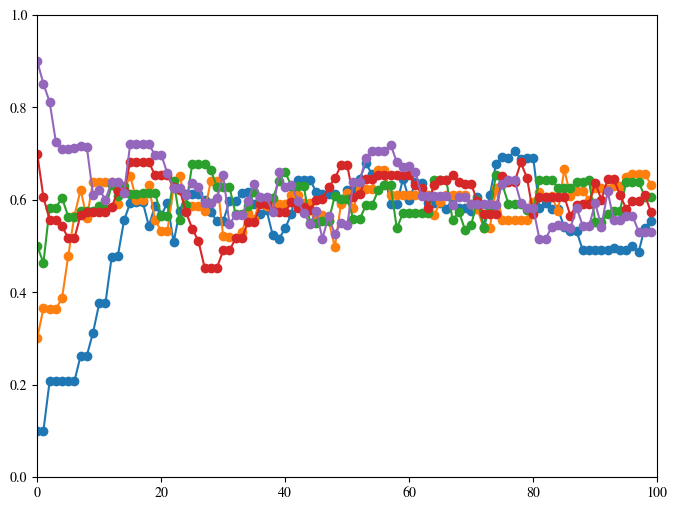

In [58]:
# compare multiple chains

plt.figure(figsize=(8, 6))

for chain in chains:
    plt.plot(chain, '-o')

plt.xlim([0, niters])
plt.ylim([0, 1]);

Was this painful to write a sampler by hand?

If not, bare in mind that we only wrote the simplest one possible! Sampling algorithms can get very complicated.

# Probabilistic programming languages (PPLs)

Luckily, we do not need to write a sampler by hand every time, because probabilistic programming languages (PPLs) are there to help.

A PPL allows to formalize a Bayesian model and perform inference with the help of powerful algorithms. A user needs to only formulate the model (and maybe chose a sampler) and press the inference button.


### 1st generation: Bugs, WinBugs, Jags, etc.

- Inference engine based on Monte Carlo methods.

- They did not scale to large data samples/high-dimensional models.

### 2nd generation: Infer.net, Factorie, Amidst, etc.

- Inference engine based on message passage algorithms and/or variational
inference methods.

- They did scale to large data samples/high-dimensional models.

- Restricted probabilistic model family (i.e. factor graphs, conjuage exponential family, etc.)

### 3rd generation: Stan, TensorFlow Probability, PyMC3, Pyro, Numpyro, Turing.jl, NIMBLE, Edward, InferPy, etc

- Hamiltonian Monte-Carlo, Black Box Variational Inference, etc

- They did scale to large data samples/high-dimensional models.

- Enable probabilistic models with deep neural networks:
  - Rely on deep learning frameworks (TensorFlow, Pytorch, Theano, etc).
  - Specialized hardware like GPUs, TPUs, etc.
  - Automatic differentiation methods.

## Introduction to NumPyro

[NumPyro](https://num.pyro.ai/en/stable/index.html) is a probabilistic programming library that provides a NumPy backend for Pyro. It relies on JAX for automatic differentiation and JIT compilation to GPU / CPU.

NumPyro provides access to a wide range of [probability distributions](https://num.pyro.ai/en/latest/distributions.html).

There is a choice of samplers which one can use to perform inference with NumPyro, with particular focus on **MCMC** algorithms.

### Coin tossing with NumPyro

In [59]:
# Numpyro
import numpyro
import numpyro.distributions as npdist
import random as rnd
from numpyro.infer import Predictive, init_to_median, MCMC, NUTS
from numpyro.diagnostics import hpdi

In [60]:
n = 100    # number of trials
h = 61     # number of successes
alpha = 2  # hyperparameters
beta = 2

niter = 1000

### Model

In [61]:
def model(n, alpha=2, beta=2, h=None):

    # prior
    p = numpyro.sample('p', npdist.Beta(alpha, beta))

    # likelihood
    numpyro.sample('obs', npdist.Binomial(n, p), obs=h)

### Prior predictive

In [62]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
prior_predictive = Predictive(model, num_samples=1000)
prior_predictions = prior_predictive(rng_key_, n)

In [63]:
prior_predictions.keys()

dict_keys(['obs', 'p'])

In [64]:
pred_obs = prior_predictions['p']
mean_prior_pred = np.mean(pred_obs, axis=0)
hpdi_prior_pred = hpdi(pred_obs, 0.89)

(array([0.46220398, 0.78061116, 1.16064536, 1.34552733, 1.3763401 ,
        1.39688334, 1.48932415, 1.20173052, 0.77033961, 0.28759363]),
 array([0.01810104, 0.11546065, 0.21282026, 0.31017989, 0.40753949,
        0.50489914, 0.60225874, 0.69961834, 0.79697794, 0.89433759,
        0.99169719]),
 <BarContainer object of 10 artists>)

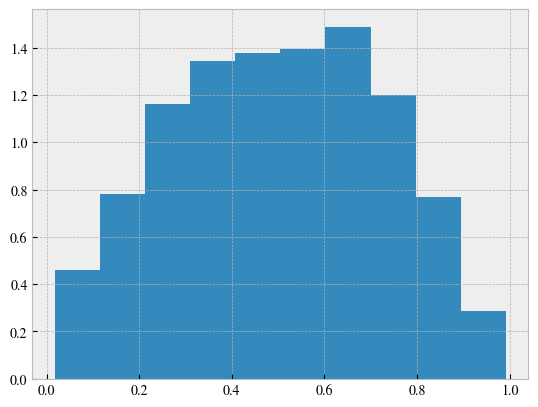

In [66]:
plt.style.use('bmh')

plt.hist(pred_obs, label = "Prior distribution", density=True)

### Inference

In [67]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# specify inference algorithm
kernel = NUTS(model)

# define number of samples and chains
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=4)

<ipython-input-67-1b14a94484e5>:8: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=4)


In [68]:
#run MCMC
mcmc.run(rng_key_, n=n, h=h)

sample: 100%|██████████| 3000/3000 [00:01<00:00, 2646.18it/s, 3 steps of size 9.60e-01. acc. prob=0.93]


In [ ]:
# inpect summary
mcmc.print_summary()

In [ ]:
p_samples = mcmc.get_samples()
p_posterior_samples = p_samples['p']

In [ ]:
plt.hist(pred_obs, label = "Prior distribution", density=True)
plt.hist(p_posterior_samples, label = "Posterior distribution", density=True)

### Check convergence

In [ ]:
import arviz as az

In [ ]:
mcmc.print_summary()
data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True);

### Posterior predicitve

In [ ]:
rng_key, rng_key_ = random.split(rng_key)
predictive = Predictive(model, p_samples)
posterior_predictions = predictive(rng_key_, n=n)
post_obs = posterior_predictions['obs']

In [ ]:
mean_post_pred = np.mean(post_obs, axis=0)
hpdi_post_pred = hpdi(post_obs, 0.9)

In [ ]:
mean_post_pred

In [ ]:
hpdi_post_pred

**Group task NN:** change hyperparamaters of the model. How are they changing the results?

## Bayesian Linear regression

In [ ]:
df = pd.read_csv("../data/Howell1.csv",sep=";")
df.head()

In [ ]:
weight = df.weight.values
height = df.height.values
weight_pred = np.array([45, 40, 65, 31, 53])

In [ ]:
plt.scatter(x='weight', y='height', data=df)

In [69]:
# model

def model(weight=None, height=None):

    # priors
    b0 = numpyro.sample('b0', dist.Normal(120,50))
    b1 = numpyro.sample('b1', dist.Normal(0,1))
    sigma = numpyro.sample('sigma', dist.HalfNormal(10.))

    # deterministic transformation
    mu = b0 + b1 * weight

    # likelihood
    numpyro.sample('obs', dist.Normal(mu, sigma), obs=height)

In [70]:
# prior predictive

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
prior_predictive = Predictive(model, num_samples=100)
prior_predictions = prior_predictive(rng_key_, weight)

NameError: ignored

In [ ]:
prior_predictions.keys()

In [ ]:
pred_obs = prior_predictions['obs']
mean_prior_pred = np.mean(pred_obs, axis=0)
hpdi_prior_pred = hpdi(pred_obs, 0.89)

In [ ]:
def plot_regression(x, y_mean, y_hpdi, height, ttl='Predictions with 89% CI)'):
    # Sort values for plotting by x axis
    idx = np.argsort(x)
    weight = x[idx]
    mean = y_mean[idx]
    hpdi = y_hpdi[:, idx]
    ht = height[idx]

    # Plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    ax.plot(weight, mean)
    ax.plot(weight, ht, 'o')
    ax.fill_between(weight, hpdi[0], hpdi[1], alpha=0.3, interpolate=True)
    ax.set(xlabel='weight', ylabel='height', title=ttl);
    return ax

In [ ]:
ax = plot_regression(weight, mean_prior_pred, hpdi_prior_pred, height, ttl="Prior predictive")

In [ ]:
# Inference

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(model)
#mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=4) # multiple chains not working! why?
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000)
mcmc.run(rng_key_, weight=weight, height=height)
mcmc.print_summary()
samples_1 = mcmc.get_samples()

In [ ]:
# Check convergence

mcmc.print_summary()
data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True);

In [ ]:
# Posterior predictive

rng_key, rng_key_ = random.split(rng_key)
predictive = Predictive(model, samples_1)
posterior_predictions = predictive(rng_key_, weight=weight)
post_obs = posterior_predictions['obs']

mean_post_pred = np.mean(post_obs, axis=0)
hpdi_post_pred = hpdi(post_obs, 0.9)

ax = plot_regression(weight, mean_post_pred, hpdi_post_pred, height, ttl="Paterior predictive")
ax.set(xlabel='weight (scaled)', ylabel='height (scaled)');

In [ ]:
# predict for new data

predictive = Predictive(model, samples_1)
predictions = predictive(rng_key_, weight=weight_pred)['obs']

mean_pred = np.mean(predictions, axis=0)
hpdi_pred = hpdi(predictions, 0.89)

d = {'weight_pred': weight_pred, 'mean_pred': mean_pred, 'lower': hpdi_pred[0,], 'upper': hpdi_pred[1,]}
df_res = pd.DataFrame(data=d)
df_res.head()

**Group task NN:** modify the model in a way that it fits better (e.g. apply transformations to input data, or try a polynomial)

## Outro

### How to chose a PPL?

- functionality (e.g. availability of discrete parameters)
- open to custom distributions (and samplers)
- preformance
- well documented
- abundant library of examples
- active (and supportive) community

### Take home messages

#### 1. Advantages of Bayesian inference

- allows to use domain knowledge about the research question
- incorporate various sources of knowledge
- can answer a broad variety of question by computing desired qunatities from posterior samples
- can work with small data

#### 2. Disadvantages of Bayesian inference

- computationally involved
- even running a model in a PPL can take a lot of time
- for MCMC moethods convergence is achieved, in theory, only at infinite number of iterations

#### 3. PPLs

- modern approach to inference
- provide the iference "button"
- only the model needs to be formulated
- each PPL has its own syntaxis


## Literuature and resources

Pyro:
- https://pyro.ai/

NumPyro:
- https://num.pyro.ai/en/stable/index.html